## Setup: ler Silver e criar colunas auxiliares de tempo

In [0]:
from pyspark.sql import functions as F

silver_table = "workspace.default.silver_games"
df = spark.table(silver_table)

# Colunas para análises temporais
df = (
    df
    .withColumn("year", F.year("game_date"))
    .withColumn("month", F.month("game_date"))
    .withColumn("year_month", F.date_format("game_date", "yyyy-MM"))
)

display(df.select("game_date","year","month","year_month","time_class","outcome").limit(10))

print("Rows:", df.count())

game_date,year,month,year_month,time_class,outcome
2018-08-05,2018,8,2018-08,bullet,white_win
2018-11-17,2018,11,2018-11,bullet,white_win
2021-05-05,2021,5,2021-05,rapid,black_win
2018-10-09,2018,10,2018-10,blitz,white_win
2021-05-05,2021,5,2021-05,rapid,black_win
2020-04-03,2020,4,2020-04,blitz,white_win
2021-02-14,2021,2,2021-02,rapid,black_win
2021-05-08,2021,5,2021-05,bullet,white_win
2021-05-05,2021,5,2021-05,rapid,white_win
2021-05-25,2021,5,2021-05,rapid,black_win


Rows: 66875


## Q1) Quantas partidas foram registradas ao longo do tempo? (tendência mensal/anual)

### Gold: gold_games_by_month

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_games_by_month AS
SELECT
  date_format(game_date, 'yyyy-MM') AS year_month,
  COUNT(*) AS n_games
FROM workspace.default.silver_games
WHERE game_date IS NOT NULL
GROUP BY date_format(game_date, 'yyyy-MM')
ORDER BY year_month;



num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT
  year_month,
  n_games
FROM workspace.default.gold_games_by_month
ORDER BY year_month;


year_month,n_games
2008-11,1
2010-08,7
2010-09,10
2010-11,1
2010-12,2
2011-01,6
2011-03,1
2011-04,4
2011-06,2
2011-07,2


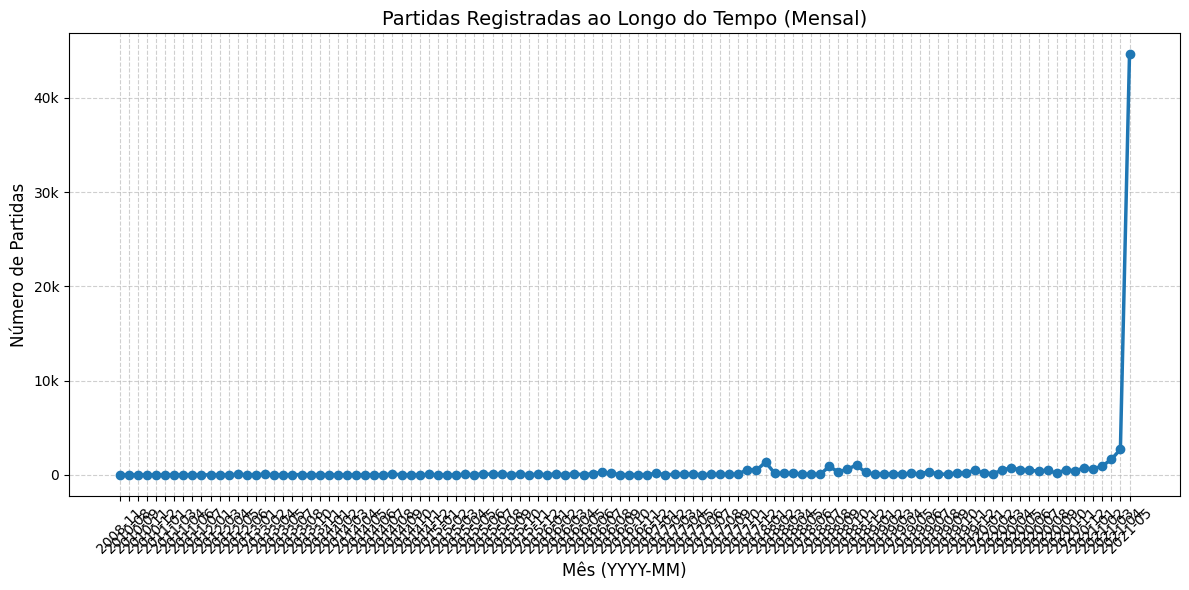

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# _sqldf é o DataFrame gerado pela célula %sql anterior
df_pandas_q1 = _sqldf.toPandas()

# Garantir ordem e tipo (year_month vem como string yyyy-MM)
df_pandas_q1["year_month"] = df_pandas_q1["year_month"].astype(str)

# Formatação do eixo Y (k / M)
def format_y_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'

plt.figure(figsize=(12, 6))
plt.plot(df_pandas_q1["year_month"], df_pandas_q1["n_games"], marker="o", linewidth=2.5)

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

plt.xlabel("Mês (YYYY-MM)", fontsize=12)
plt.ylabel("Número de Partidas", fontsize=12)
plt.title("Partidas Registradas ao Longo do Tempo (Mensal)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Gold: gold_games_by_year

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_games_by_year AS
SELECT
  year(game_date) AS year,
  COUNT(*) AS n_games
FROM workspace.default.silver_games
WHERE game_date IS NOT NULL
GROUP BY year(game_date)
ORDER BY year;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT
  year,
  n_games
FROM workspace.default.gold_games_by_year
ORDER BY year;


year,n_games
2008,1
2010,20
2011,15
2012,96
2013,147
2014,191
2015,543
2016,965
2017,1754
2018,5206


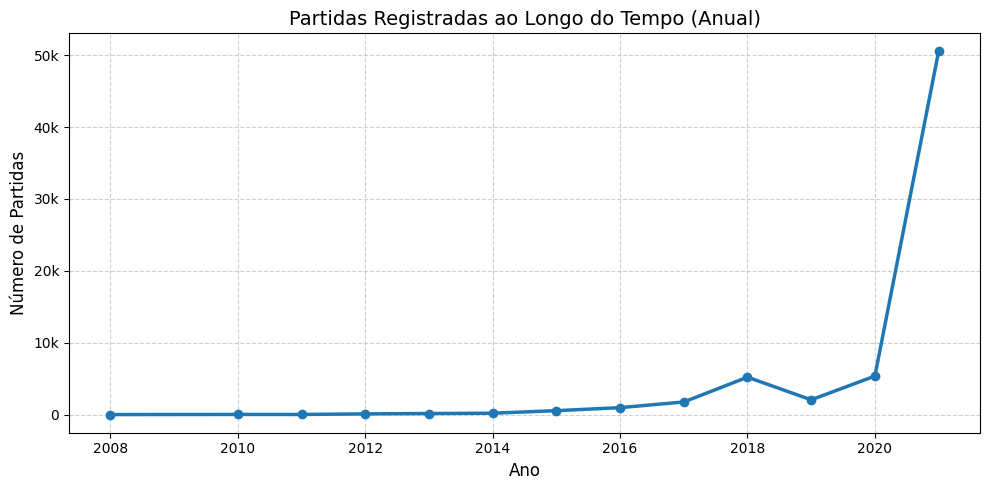

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df_pandas_q1y = _sqldf.toPandas()

def format_y_axis(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    if x >= 1e3:
        return f'{x*1e-3:.0f}k'
    return f'{x:.0f}'

plt.figure(figsize=(10, 5))
plt.plot(df_pandas_q1y["year"], df_pandas_q1y["n_games"], marker="o", linewidth=2.5)

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))

plt.xlabel("Ano", fontsize=12)
plt.ylabel("Número de Partidas", fontsize=12)
plt.title("Partidas Registradas ao Longo do Tempo (Anual)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Análise do resultado (Q1)

Pelos gráficos, é possível visualizar como as partidas do dataset se distribuem ao longo do tempo. A maior parte dos meses apresenta volumes baixos, enquanto nos meses finais do dataset há um crescimento forte, em especial no último, culminando em um pico muito acima do restante da série.

Esse comportamento sugere que o conjunto de dados está concentrado em um período específico (principalmente mais recente), o que é compatível com dataset não oficiais de bases comunitárias.

Portanto, a tendência observada deve ser interpretada como o comportamento da amostra disponível neste dataset, e não como uma tendência histórica completa do Chess.com.

## Q2) Qual a distribuição de resultados (vitória/empate/derrota) no geral e por time_class?


### Gold: gold_outcomes_overall

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_outcomes_overall AS
WITH base AS (
  SELECT outcome, COUNT(*) AS n_games
  FROM workspace.default.silver_games
  GROUP BY outcome
),
tot AS (
  SELECT SUM(n_games) AS total_games FROM base
)
SELECT
  b.outcome,
  b.n_games,
  b.n_games / t.total_games AS pct
FROM base b
CROSS JOIN tot t
ORDER BY b.n_games DESC;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT outcome, n_games, pct
FROM workspace.default.gold_outcomes_overall
ORDER BY n_games DESC;


outcome,n_games,pct
white_win,33349,0.4986766355140187
black_win,31215,0.46676635514018694
draw,2311,0.03455700934579439


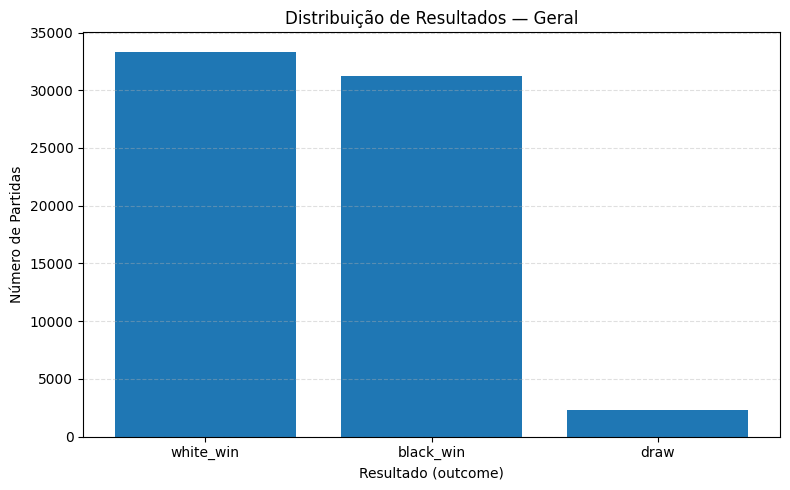

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# _sqldf é o DataFrame gerado pela célula %sql anterior
df_overall = _sqldf.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(df_overall["outcome"], df_overall["n_games"])

plt.title("Distribuição de Resultados — Geral")
plt.xlabel("Resultado (outcome)")
plt.ylabel("Número de Partidas")

plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Gold: gold_outcomes_by_time_class

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_outcomes_by_time_class AS
WITH base AS (
  SELECT
    time_class,
    outcome,
    COUNT(*) AS n_games
  FROM workspace.default.silver_games
  GROUP BY time_class, outcome
),
tot AS (
  SELECT
    time_class,
    SUM(n_games) AS total_games
  FROM base
  GROUP BY time_class
)
SELECT
  b.time_class,
  b.outcome,
  b.n_games,
  b.n_games / t.total_games AS pct
FROM base b
JOIN tot t
  ON b.time_class = t.time_class
ORDER BY b.time_class, b.n_games DESC;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT time_class, outcome, pct
FROM workspace.default.gold_outcomes_by_time_class
ORDER BY time_class, outcome;


time_class,outcome,pct
blitz,black_win,0.4616872539704086
blitz,draw,0.03878783765440478
blitz,white_win,0.49952490837518665
bullet,black_win,0.4762455001999911
bullet,draw,0.02217679214257144
bullet,white_win,0.5015777076574375
daily,black_win,0.481500253421186
daily,draw,0.02483527622909275
daily,white_win,0.4936644703497212
rapid,black_win,0.4595994742132529


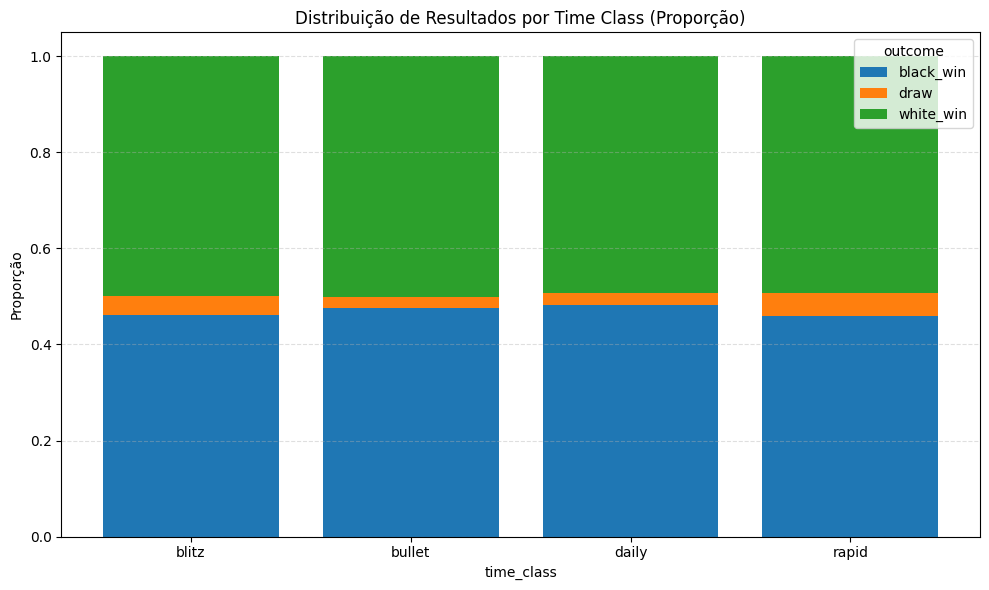

In [0]:
import matplotlib.pyplot as plt

# _sqldf é o DataFrame gerado pela célula %sql anterior
df_tc = _sqldf.toPandas()

# Pivot: linhas=time_class, colunas=outcome, valores=pct
pivot = df_tc.pivot(index="time_class", columns="outcome", values="pct").fillna(0)

plt.figure(figsize=(10, 6))
bottom = None

for col in pivot.columns:
    if bottom is None:
        plt.bar(pivot.index, pivot[col], label=col)
        bottom = pivot[col].values
    else:
        plt.bar(pivot.index, pivot[col], bottom=bottom, label=col)
        bottom = bottom + pivot[col].values

plt.title("Distribuição de Resultados por Time Class (Proporção)")
plt.xlabel("time_class")
plt.ylabel("Proporção")
plt.legend(title="outcome")

plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Análise do resultado (Q2)

No consolidado geral, observa-se que vitórias das brancas (white_win) são ligeiramente mais frequentes do que vitórias das pretas (black_win), enquanto empates (draw) representam uma parcela pequena do total de partidas. Isso é consistente com partidas online em controles mais rápidos, onde empates tendem a ser menos comuns, inclusive devido à desistência prematura.

Ao segmentar por time_class (barras empilhadas em proporção), a distribuição de resultados é bastante parecida entre blitz, bullet, rapid e daily, sem mudanças drásticas na distribuição de vitórias/empates. Ainda assim, os que empates continuam baixos em todas as modalidades, e que a diferença entre vitórias de brancas e pretas se mantém relativamente estável, independentemente dos controles de tempo.

Em resumo, para esta amostra, o fator “modalidade de tempo” parece não alterar significativamente a distribuição geral de resultados, e os empates permanecem eventos menos frequentes no dataset.

## Q3) Existe vantagem estatística para as BRANCAS? (taxa de vitória BRANCAS vs PRETAS)

### Gold: gold_white_advantage

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_white_advantage AS
SELECT
  -- contagens
  SUM(CASE WHEN outcome = 'white_win' THEN 1 ELSE 0 END) AS white_wins,
  SUM(CASE WHEN outcome = 'black_win' THEN 1 ELSE 0 END) AS black_wins,
  SUM(CASE WHEN outcome = 'draw'      THEN 1 ELSE 0 END) AS draws,
  COUNT(*) AS n_games,

  -- base decidida (sem empates)
  SUM(CASE WHEN outcome IN ('white_win','black_win') THEN 1 ELSE 0 END) AS decided_games,

  -- taxas sem empates (Brancas vs Pretas)
  SUM(CASE WHEN outcome = 'white_win' THEN 1 ELSE 0 END)
  / NULLIF(SUM(CASE WHEN outcome IN ('white_win','black_win') THEN 1 ELSE 0 END), 0) AS white_win_rate_no_draw,

  SUM(CASE WHEN outcome = 'black_win' THEN 1 ELSE 0 END)
  / NULLIF(SUM(CASE WHEN outcome IN ('white_win','black_win') THEN 1 ELSE 0 END), 0) AS black_win_rate_no_draw
FROM workspace.default.silver_games;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT white_win_rate_no_draw, black_win_rate_no_draw
FROM workspace.default.gold_white_advantage;


white_win_rate_no_draw,black_win_rate_no_draw
0.5165262375317514,0.4834737624682486


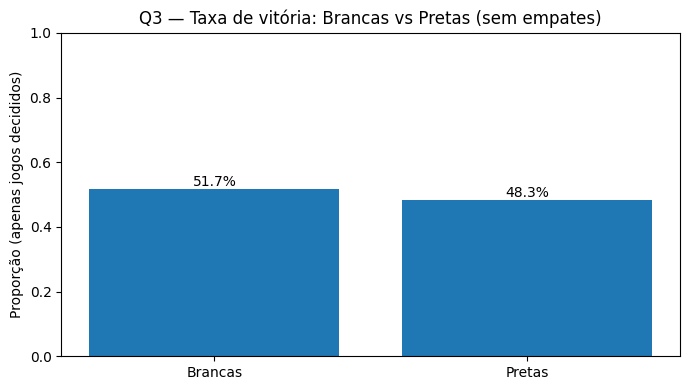

In [0]:
import matplotlib.pyplot as plt

# _sqldf é o DataFrame gerado pela célula %sql anterior
df = _sqldf.toPandas()

white = float(df.loc[0, "white_win_rate_no_draw"])
black = float(df.loc[0, "black_win_rate_no_draw"])

labels = ["Brancas", "Pretas"]
values = [white, black]

plt.figure(figsize=(7,4))
bars = plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Proporção (apenas jogos decididos)")
plt.title("Q3 — Taxa de vitória: Brancas vs Pretas (sem empates)")

for b, v in zip(bars, values):
    plt.text(b.get_x() + b.get_width()/2, v + 0.01, f"{v*100:.1f}%", ha="center")

plt.tight_layout()
plt.show()


### Gold: gold_white_advantage_by_time_class

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_white_advantage_by_time_class AS
SELECT
  time_class,
  COUNT(*) AS n_games,
  SUM(CASE WHEN outcome = 'white_win' THEN 1 ELSE 0 END) AS white_wins,
  SUM(CASE WHEN outcome = 'black_win' THEN 1 ELSE 0 END) AS black_wins,
  SUM(CASE WHEN outcome = 'draw'      THEN 1 ELSE 0 END) AS draws,
  SUM(CASE WHEN outcome IN ('white_win','black_win') THEN 1 ELSE 0 END) AS decided_games,

  -- win rate sem empates (principal da Q3)
  SUM(CASE WHEN outcome = 'white_win' THEN 1 ELSE 0 END)
    / NULLIF(SUM(CASE WHEN outcome IN ('white_win','black_win') THEN 1 ELSE 0 END), 0) AS white_win_rate_no_draw,

  SUM(CASE WHEN outcome = 'black_win' THEN 1 ELSE 0 END)
    / NULLIF(SUM(CASE WHEN outcome IN ('white_win','black_win') THEN 1 ELSE 0 END), 0) AS black_win_rate_no_draw,

  -- só para contexto
  SUM(CASE WHEN outcome = 'draw' THEN 1 ELSE 0 END) / COUNT(*) AS draw_rate
FROM workspace.default.silver_games
GROUP BY time_class
ORDER BY time_class;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT *
FROM workspace.default.gold_white_advantage_by_time_class
ORDER BY time_class;


time_class,n_games,white_wins,black_wins,draws,decided_games,white_win_rate_no_draw,black_win_rate_no_draw,draw_rate
blitz,29468,14720,13605,1143,28325,0.5196822594880848,0.4803177405119153,0.03878783765440478
bullet,22501,11286,10716,499,22002,0.5129533678756477,0.48704663212435234,0.02217679214257144
daily,1973,974,950,49,1924,0.5062370062370062,0.49376299376299376,0.02483527622909275
rapid,12933,6369,5944,620,12313,0.5172581824088361,0.4827418175911638,0.04793937988092477


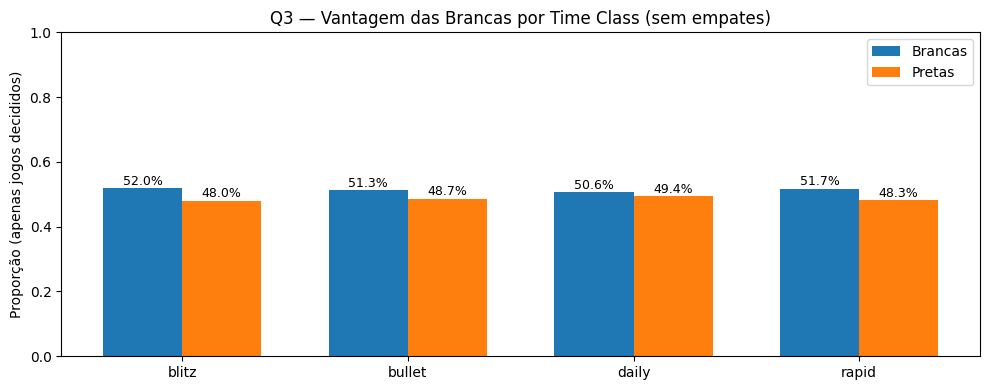

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# _sqldf é o DataFrame gerado pela célula %sql anterior
df = _sqldf.toPandas().sort_values("time_class")

x = np.arange(len(df["time_class"]))
w = 0.35

white = df["white_win_rate_no_draw"].astype(float).values
black = df["black_win_rate_no_draw"].astype(float).values

plt.figure(figsize=(10,4))
b1 = plt.bar(x - w/2, white, width=w, label="Brancas")
b2 = plt.bar(x + w/2, black, width=w, label="Pretas")

plt.xticks(x, df["time_class"])
plt.ylim(0, 1)
plt.ylabel("Proporção (apenas jogos decididos)")
plt.title("Q3 — Vantagem das Brancas por Time Class (sem empates)")
plt.legend()

for bars in [b1, b2]:
    for b in bars:
        v = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, v + 0.01, f"{v*100:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


### Análise do Resultado (Q3)

Considerando apenas partidas com vencedor (excluindo empates), as **brancas** apresentam uma taxa de vitória **ligeiramente superior** às pretas em todas as modalidades:

| Modalidade de tempo | Brancas | Pretas  |
| ------------------- | ------- | ------- |
| **Blitz:**          | ~52,0%  | ~48,0%  |
| **Bullet:**         | ~51,3%  | ~48,7%  |
| **Daily:**          | ~50,6%  | ~49,4%  | 
| **Rapid:**          | ~51,7%  | ~48,3%  |

Isso sugere uma **pequena vantagem do primeiro lance**, consistente entre os diferentes `time_class`. A diferença é modesta e deve ser interpretada no contexto do dataset utilizado.

> OBS: Esta pergunta já estava praticamente respondida pelas distribuições anteriores, mas decidi mantê-la por consistência com as perguntas previamente definidas no README.


## Q4) Como a diferença de rating (white_rating - black_rating) influencia o resultado da partida?

### Gold: gold_outcome_by_rating_diff_bin

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_outcome_by_rating_diff_bin AS
WITH base AS (
  SELECT
    CAST(white_rating - black_rating AS INT) AS rating_diff,
    outcome
  FROM workspace.default.silver_games
  WHERE outcome IN ('white_win','black_win','draw')
),
binned AS (
  SELECT
    CAST(FLOOR(rating_diff / 200.0) * 200 AS INT) AS bin_start,
    outcome
  FROM base
),
agg AS (
  SELECT
    bin_start,
    outcome,
    COUNT(*) AS n_games
  FROM binned
  GROUP BY bin_start, outcome
),
final AS (
  SELECT
    bin_start,
    bin_start + 199 AS bin_end,
    outcome,
    n_games,
    n_games / SUM(n_games) OVER (PARTITION BY bin_start) AS pct_in_bin,
    SUM(n_games) OVER (PARTITION BY bin_start) AS n_bin_total
  FROM agg
)
SELECT *
FROM final
ORDER BY bin_start, outcome;


num_affected_rows,num_inserted_rows


In [0]:
%sql 
SELECT bin_start, bin_end, outcome, pct_in_bin
FROM workspace.default.gold_outcome_by_rating_diff_bin
ORDER BY bin_start, outcome;




bin_start,bin_end,outcome,pct_in_bin
-2200,-2001,black_win,1.0
-2000,-1801,black_win,1.0
-1600,-1401,black_win,1.0
-1400,-1201,black_win,0.975
-1400,-1201,white_win,0.025
-1200,-1001,black_win,0.9538461538461539
-1200,-1001,white_win,0.046153846153846156
-1000,-801,black_win,0.9664429530201343
-1000,-801,draw,0.006711409395973154
-1000,-801,white_win,0.026845637583892617


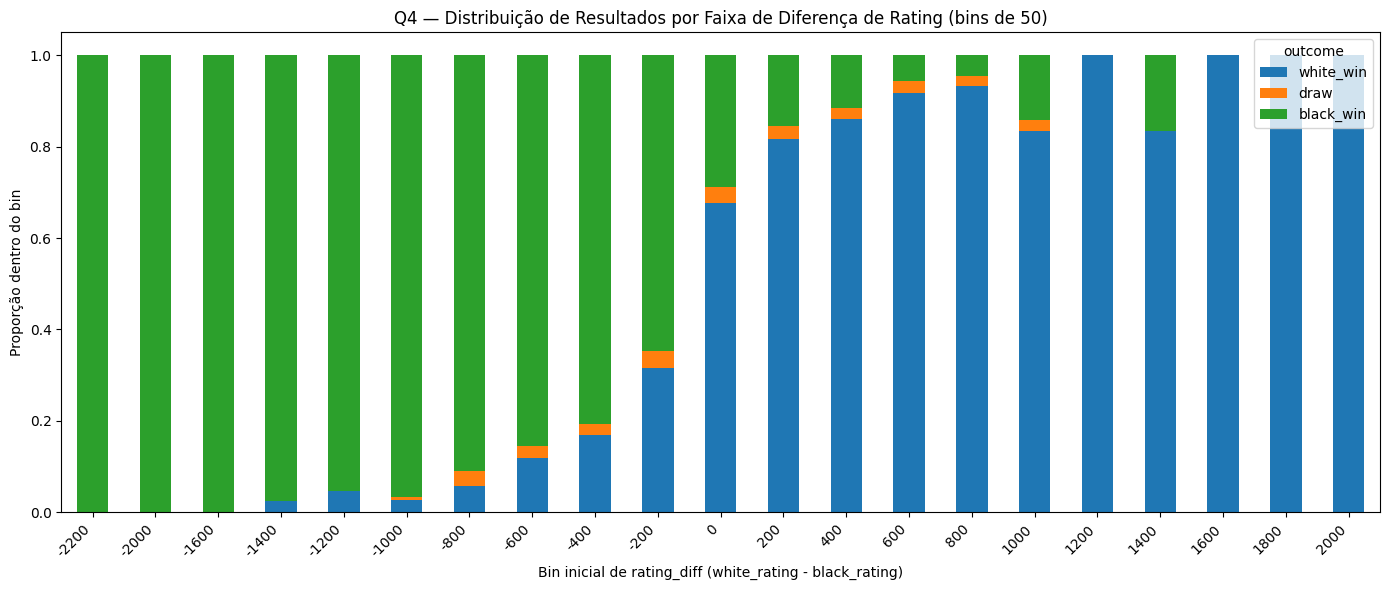

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# _sqldf é o DataFrame gerado pela célula %sql anterior
df_q4 = _sqldf.toPandas()

pivot = (
    df_q4.pivot_table(
        index="bin_start",
        columns="outcome",
        values="pct_in_bin",
        aggfunc="sum",
        fill_value=0.0
    )
    .sort_index()
)

# ordena as colunas
col_order = [c for c in ["white_win", "draw", "black_win"] if c in pivot.columns]
pivot = pivot[col_order] if col_order else pivot

# Plot de barras empilhadas
ax = pivot.plot(kind="bar", stacked=True, figsize=(14, 6))
ax.set_title("Q4 — Distribuição de Resultados por Faixa de Diferença de Rating (bins de 200)")
ax.set_xlabel("Bin inicial de rating_diff (white_rating - black_rating)")
ax.set_ylabel("Proporção dentro do bin")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Análise do Resultado (Q4)

À medida que a diferença de rating aumenta a favor das BRANCAS (white_rating > black_rating), a proporção de vitórias das brancas cresce de forma clara. Quando a diferença é negativa (pretas mais fortes), ocorre o inverso: aumenta a proporção de vitórias das pretas.

Quando os ratings são semelhantes (próximos de zero), os resultados ficam mais equilibrados e aparecem mais empates. Nas extremidades, as faixas possuem menos partidas e, portanto, devem ser interpretadas com cautela.

## Q5) Como os tipos de término variam por controle de tempo? (ex.: checkmated, resigned, timeout, abandoned, etc.)


### Gold: gold_termination_by_time_class

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_termination_by_time_class AS
WITH base AS (
  SELECT
    time_class,
    COALESCE(NULLIF(TRIM(LOWER(termination_type)), ''), 'unknown') AS termination_type
  FROM workspace.default.silver_games
),
agg AS (
  SELECT
    time_class,
    termination_type,
    COUNT(*) AS n_games
  FROM base
  GROUP BY time_class, termination_type
),
final AS (
  SELECT
    time_class,
    termination_type,
    n_games,
    n_games / SUM(n_games) OVER (PARTITION BY time_class) AS pct_in_time_class
  FROM agg
)
SELECT *
FROM final
ORDER BY time_class, n_games DESC;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT
  time_class,
  termination_type,
  n_games,
  pct_in_time_class
FROM workspace.default.gold_termination_by_time_class
ORDER BY time_class, n_games DESC;


time_class,termination_type,n_games,pct_in_time_class
blitz,resigned,12586,0.42710737070720783
blitz,checkmated,8004,0.2716166689290077
blitz,timeout,5866,0.19906339079679652
blitz,abandoned,1589,0.053922899416316006
blitz,game drawn by repetition,380,0.01289534410207683
blitz,game drawn by stalemate,241,0.008178362970001357
blitz,game drawn by insufficient material,192,0.006515542283154608
blitz,game drawn by timeout vs insufficient material,189,0.006413736934980318
blitz,threecheck,167,0.005667164381702185
blitz,game drawn by agreement,136,0.004615175783901181


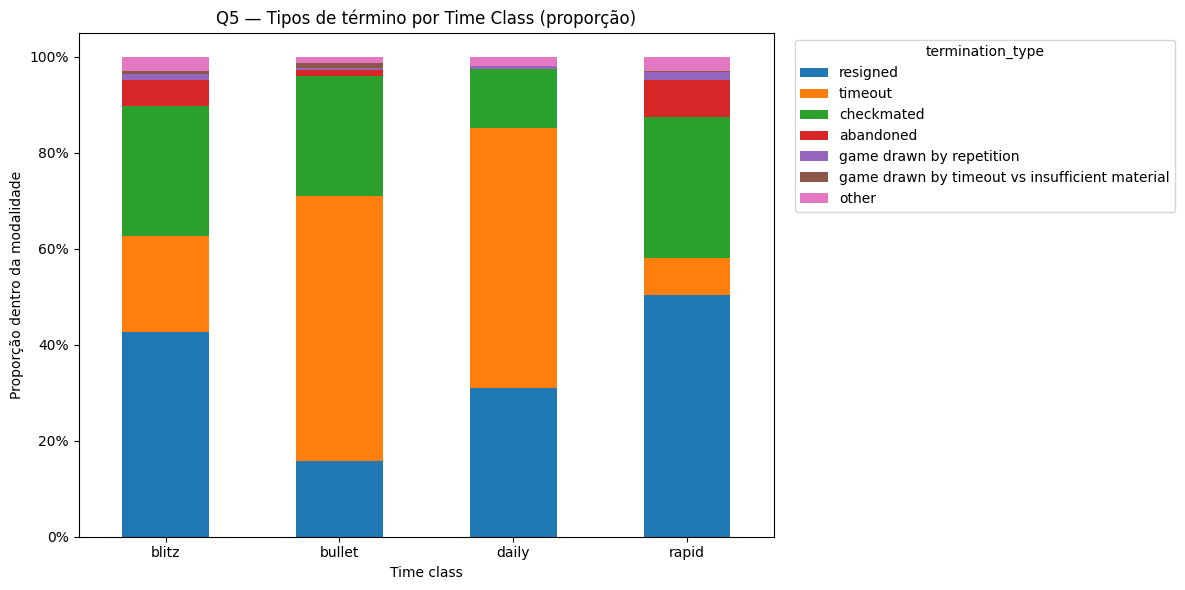

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

TOP_N = 6  # ajuste se quiser mais/menos categorias

# _sqldf é o DataFrame gerado pela célula %sql anterior
df = _sqldf.toPandas().copy()

# Garantir tipos
df["pct_in_time_class"] = df["pct_in_time_class"].astype(float)
df["n_games"] = df["n_games"].astype(int)

# Escolher TOP_N terminações mais frequentes no dataset inteiro (por volume)
top_terms = (
    df.groupby("termination_type")["n_games"].sum()
      .sort_values(ascending=False)
      .head(TOP_N)
      .index
      .tolist()
)

# Agrupar o resto em "other"
df["termination_group"] = df["termination_type"].where(df["termination_type"].isin(top_terms), "other")

df_grouped = (
    df.groupby(["time_class", "termination_group"], as_index=False)
      .agg({"pct_in_time_class": "sum"})
)

# Pivot para plot empilhado
pivot = (
    df_grouped.pivot(index="time_class", columns="termination_group", values="pct_in_time_class")
              .fillna(0.0)
)

# (Opcional) ordenar colunas: top_terms primeiro, depois other
ordered_cols = [c for c in top_terms if c in pivot.columns] + ([ "other" ] if "other" in pivot.columns else [])
pivot = pivot[ordered_cols] if ordered_cols else pivot

ax = pivot.plot(kind="bar", stacked=True, figsize=(12, 6))

ax.set_title("Q5 — Tipos de término por Time Class (proporção)")
ax.set_xlabel("Time class")
ax.set_ylabel("Proporção dentro da modalidade")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=0)
plt.legend(title="termination_type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



### Análise do Resultado (Q5)

O gráfico mostra que os tipos de término variam bastante conforme o time_class, principalmente entre bullet e as modalidades mais longas.

- Bullet é claramente dominado por timeout (a maior fatia), o que faz sentido pela alta pressão de tempo e decisões rápidas.

- Rapid apresenta predominância de resigned, indicando mais partidas encerradas por desistência do jogador (jogos mais “controlados”, com mais margem para avaliar posição e abandonar).

- Daily também é fortemente concentrado em timeout, sugerindo que muitos jogos são encerrados por falta de resposta dentro do prazo.

No geral, quanto mais rápido o controle, maior a influência do relógio (timeout); e quanto mais “lento/gerenciável” o jogo, maior a participação de desistências (resigned) e outros encerramentos.


## Q6) Quais são as aberturas (ECO) mais frequentes e como isso varia por time_class?

### Gold: gold_eco_overall

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_eco_overall AS
WITH base AS (
  SELECT
    COALESCE(NULLIF(TRIM(pgn_eco), ''), 'UNKNOWN') AS eco,
    COUNT(*) AS n_games
  FROM workspace.default.silver_games
  GROUP BY 1
)
SELECT
  eco,
  n_games,
  n_games / SUM(n_games) OVER () AS pct
FROM base
ORDER BY n_games DESC;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * 
FROM workspace.default.gold_eco_overall
ORDER BY n_games DESC
LIMIT 30;

eco,n_games,pct
A00,5390,0.0805981308411215
B01,3716,0.055566355140186915
A40,3652,0.05460934579439252
D00,3151,0.04711775700934579
C00,3136,0.046893457943925236
C20,2883,0.04311028037383178
B00,2874,0.04297570093457944
B20,1719,0.025704672897196263
C41,1661,0.024837383177570095
B07,1488,0.022250467289719626


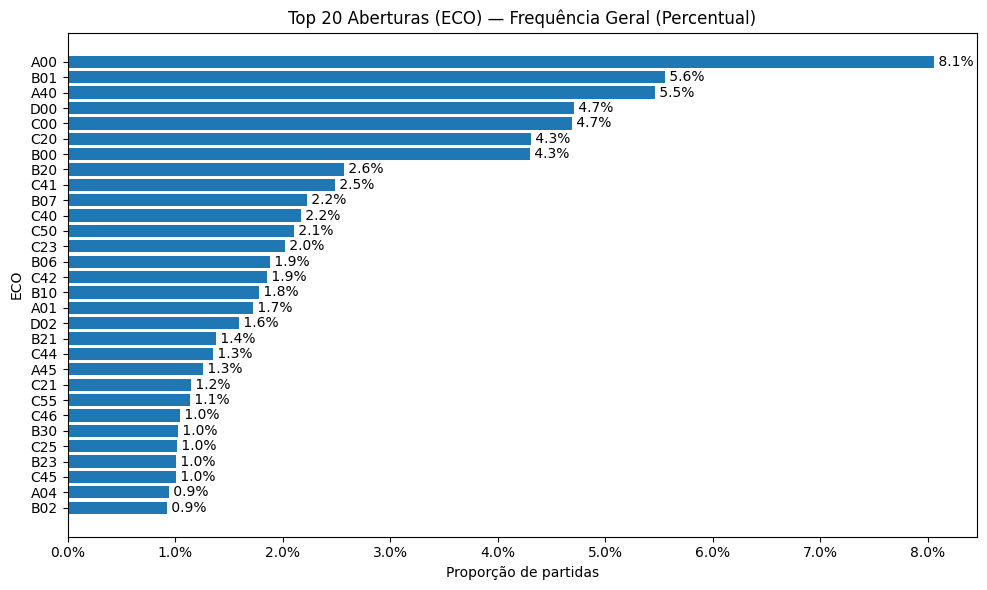

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd

# _sqldf é o DataFrame gerado pela célula %sql anterior
df_eco = _sqldf.toPandas().copy()

df_eco["pct"] = pd.to_numeric(df_eco["pct"], errors="coerce")
df_eco = df_eco.sort_values("pct", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_eco["eco"], df_eco["pct"])
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel("Proporção de partidas")
plt.ylabel("ECO")
plt.title("Top 30 Aberturas (ECO) — Frequência Geral (Percentual)")

# rótulos corretos em %
for i, v in enumerate(df_eco["pct"]):
    plt.text(v, i, f" {v*100:.1f}%", va="center")

plt.tight_layout()
plt.show()


### Gold: gold_eco_by_time_class_top15 

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_eco_by_time_class_top15 AS
WITH base AS (
  SELECT
    time_class,
    COALESCE(NULLIF(TRIM(pgn_eco), ''), 'UNKNOWN') AS eco,
    COUNT(*) AS n_games
  FROM workspace.default.silver_games
  GROUP BY 1, 2
),
with_pct AS (
  SELECT
    time_class,
    eco,
    n_games,
    n_games / SUM(n_games) OVER (PARTITION BY time_class) AS pct_in_time_class
  FROM base
),
ranked AS (
  SELECT *,
         ROW_NUMBER() OVER (PARTITION BY time_class ORDER BY n_games DESC) AS rn
  FROM with_pct
)
SELECT
  time_class,
  eco,
  n_games,
  pct_in_time_class
FROM ranked
WHERE rn <= 15
ORDER BY time_class, n_games DESC;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT *
FROM workspace.default.gold_eco_by_time_class_top15
ORDER BY time_class, n_games DESC;


time_class,eco,n_games,pct_in_time_class
blitz,A00,1823,0.06186371657391068
blitz,D00,1608,0.05456766662141985
blitz,C20,1565,0.053108456630921674
blitz,B01,1520,0.05158137640830732
blitz,C00,1337,0.04537125016967558
blitz,A40,1302,0.04418352110764219
blitz,B00,1139,0.03865209719017239
blitz,B20,820,0.027826795167639473
blitz,C41,814,0.02762318447129089
blitz,C23,681,0.023109814035564002


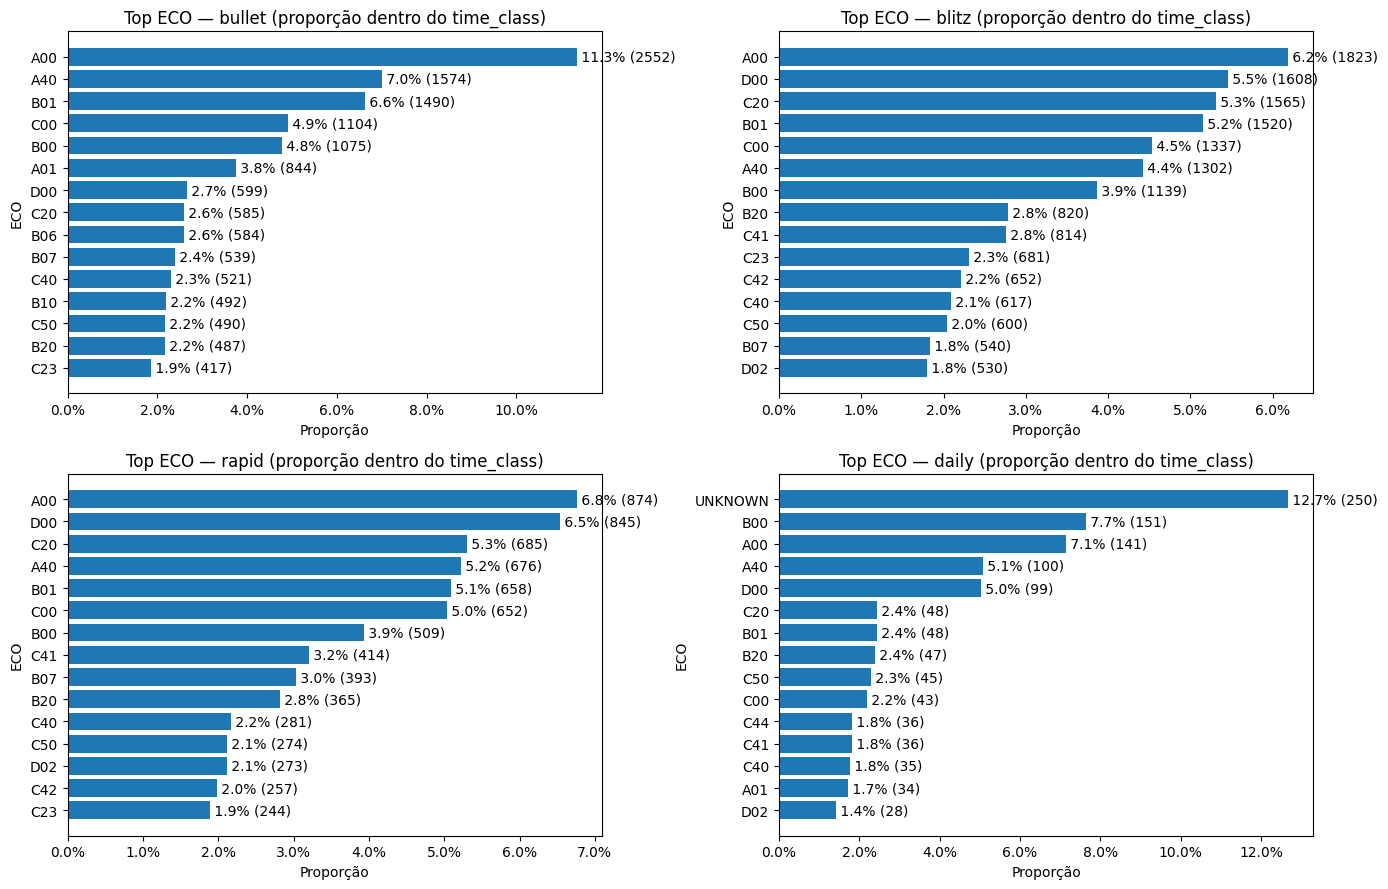

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# _sqldf é o DataFrame gerado pela célula %sql anterior
df = _sqldf.toPandas().copy()

# garantir tipo numérico
df["pct_in_time_class"] = pd.to_numeric(df["pct_in_time_class"], errors="coerce")
df["n_games"] = pd.to_numeric(df["n_games"], errors="coerce")

# ordem desejada (opcional)
order_tc = ["bullet", "blitz", "rapid", "daily"]
time_classes = [tc for tc in order_tc if tc in df["time_class"].unique()] + \
               [tc for tc in df["time_class"].unique() if tc not in order_tc]

ncols = 2
nrows = (len(time_classes) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4.5*nrows))
axes = axes.flatten()

for i, tc in enumerate(time_classes):
    ax = axes[i]
    sub = df[df["time_class"] == tc].sort_values("pct_in_time_class", ascending=True)

    ax.barh(sub["eco"], sub["pct_in_time_class"])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(f"Top ECO — {tc} (proporção dentro do time_class)")
    ax.set_xlabel("Proporção")
    ax.set_ylabel("ECO")

    # rótulo com % e volume
    for y, (pct, n) in enumerate(zip(sub["pct_in_time_class"], sub["n_games"])):
        ax.text(pct, y, f" {pct*100:.1f}% ({int(n)})", va="center")

# desliga eixos vazios
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### Análise do Resultado (Q6)

No geral, as aberturas mais frequentes ficam relativamente bem distribuídas, sem um único ECO dominante. Ainda assim, há um topo claro: A00 (\~8,1%) aparece como a abertura mais comum, seguida por B01 (\~5,6%) e A40 (\~5,5%). Depois disso, vários ECOs aparecem em uma faixa próxima, indicando variedade alta de escolhas de abertura neste dataset.

Por time_class, o padrão muda:
- **Bullet** mostra uma concentração maior em A00 (~11,3%), o que é consistente com a hipótese de que em partidas muito rápidas há mais aberturas “genéricas”/menos teóricas (ou mais difíceis de classificar oficialmente).
- **Blitz** fica mais parecido com o geral, com A00 e outros ECOs tradicionais bem presentes, mas sem tanta concentração quanto no bullet.
- **Rapid** tende a ficar mais equilibrado entre os principais ECOs, sem um pico tão alto quanto o bullet, sugerindo mais consistência nas escolhas.
- **Daily** chama atenção por aparecer UNKNOWN no topo (e com percentual alto). Isso indica ECO ausente ou inconsistente no PGN e também pode ser efeito de amostra menor, deixando as proporções mais voláteis.

Há um conjunto de ECOs recorrentes no dataset, mas a distribuição varia com o ritmo; quanto mais rápido o jogo, maior a tendência de concentração em aberturas mais genéricas e/ou maior ruído de classificação, e no daily o principal destaque é a incompletude do ECO.

## Q7) Quais aberturas (ECO) têm melhor desempenho (win rate), considerando um mínimo de jogos para reduzir viés de amostra pequena?

### Gold: gold_eco_performance_min50

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_eco_performance_min50 AS
WITH base AS (
  SELECT
    COALESCE(NULLIF(TRIM(pgn_eco), ''), 'UNKNOWN') AS eco,
    outcome
  FROM workspace.default.silver_games
  WHERE outcome IN ('white_win','black_win','draw')
    AND pgn_eco RLIKE '^[A-E][0-9]{2}$'          -- mantém só ECO válido
),
agg AS (
  SELECT
    eco,
    COUNT(*) AS n_games,
    AVG(CASE WHEN outcome = 'white_win' THEN 1.0 ELSE 0.0 END) AS white_win_rate,
    AVG(CASE WHEN outcome = 'draw'      THEN 1.0 ELSE 0.0 END) AS draw_rate,
    AVG(CASE WHEN outcome = 'black_win' THEN 1.0 ELSE 0.0 END) AS black_win_rate,
    AVG(CASE
          WHEN outcome = 'white_win' THEN 1.0
          WHEN outcome = 'draw'      THEN 0.5
          WHEN outcome = 'black_win' THEN 0.0
        END) AS white_score_avg
  FROM base
  GROUP BY eco
)
SELECT *
FROM agg
WHERE n_games >= 50
ORDER BY white_win_rate DESC, n_games DESC;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT
  eco,
  n_games,
  white_win_rate
FROM workspace.default.gold_eco_performance_min50
ORDER BY white_win_rate DESC, n_games DESC
LIMIT 20;


eco,n_games,white_win_rate
B44,61,0.60656
C28,159,0.60377
C54,80,0.60000
A07,97,0.59794
B33,197,0.59391
C70,63,0.58730
C64,177,0.58192
C65,147,0.56463
D08,103,0.56311
C34,230,0.56087


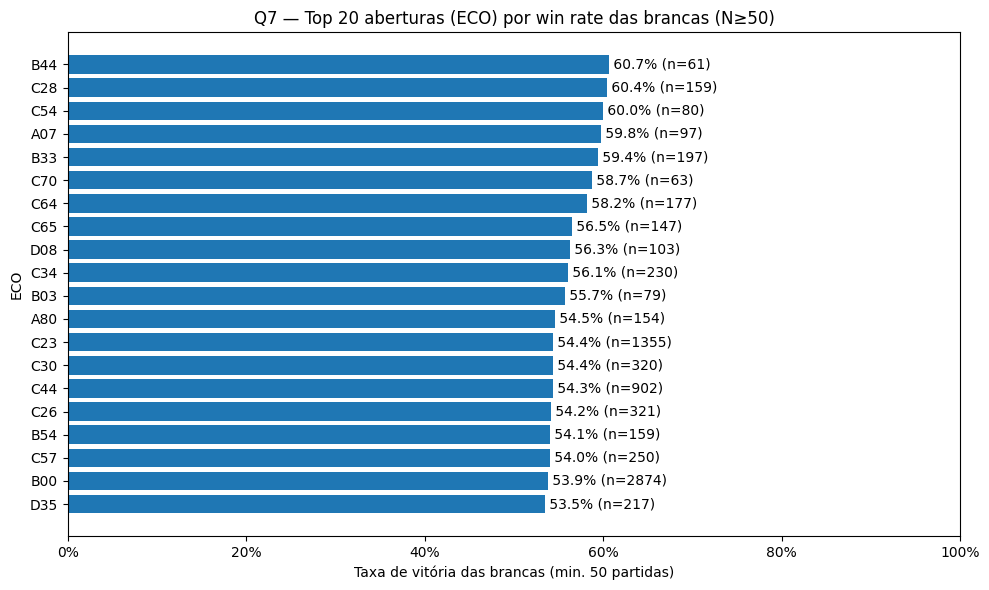

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# _sqldf é o DataFrame gerado pela célula %sql anterior
df_top20 = _sqldf.toPandas().copy()
df_top20 = df_top20.sort_values("white_win_rate", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_top20["eco"], df_top20["white_win_rate"])

ax = plt.gca()
ax.set_xlim(0, 1.0)  # 0% a 100%
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel("Taxa de vitória das brancas (min. 50 partidas)")
plt.ylabel("ECO")
plt.title("Q7 — Top 20 aberturas (ECO) por win rate das brancas (N≥50)")

for i, (wr, n) in enumerate(zip(df_top20["white_win_rate"], df_top20["n_games"])):
    plt.text(wr, i, f" {wr*100:.1f}% (n={int(n)})", va="center")

plt.tight_layout()
plt.show()


### Análise do Resultado (Q7)

Considerando apenas aberturas com pelo menos 50 partidas (para reduzir viés de amostra pequena), vemos que algumas aberturas apresentam taxas de vitória das brancas acima do padrão observado no geral.

No Top 20, as maiores taxas ficam em torno de ~60% (ex.: B44 ~60,7%, C28 ~60,4%, C54 ~60,0%). Ainda assim, várias dessas aberturas têm amostras pequenas (ex.: n≈60-200), o que pode inflar um pouco as proporções.

Por outro lado, há aberturas com amostras bem maiores e ainda assim com desempenho consistente para as brancas. Um exemplo claro é C23 (n≈1355), que aparece com win rate de \~54%, sugerindo um padrão mais estável. Também aparecem códigos com volume alto (ex.: B00 (n≈2874)) com win rate por \~54%, indicando que mesmo em aberturas muito comuns as brancas mantêm uma leve vantagem.

O gráfico sugere que existem aberturas onde as brancas performam melhor, mas a interpretação deve sempre ponderar o tamanho da amostra; os resultados mais confiáveis tendem a ser os ECOs com n mais alto, mesmo que o win rate seja menos “extremo” que os primeiros colocados.

## Q8) Quais jogadores mais participam e como performam (volume de jogos e score/win rate), especialmente por modalidade?

### Gold: gold_player_stats_by_time_class

In [0]:
%sql
CREATE OR REPLACE TABLE workspace.default.gold_player_stats_by_time_class AS
WITH player_games AS (
  -- White side
  SELECT
    time_class,
    COALESCE(NULLIF(TRIM(white_username), ''), white_id) AS player,
    white_score AS score
  FROM workspace.default.silver_games

  UNION ALL

  -- Black side
  SELECT
    time_class,
    COALESCE(NULLIF(TRIM(black_username), ''), black_id) AS player,
    black_score AS score
  FROM workspace.default.silver_games
),
agg AS (
  SELECT
    time_class,
    player,
    COUNT(*) AS n_games,
    AVG(CASE WHEN score = 1.0 THEN 1.0 ELSE 0.0 END) AS win_rate,
    AVG(score) AS avg_score
  FROM player_games
  WHERE player IS NOT NULL
  GROUP BY time_class, player
)
SELECT *
FROM agg;


num_affected_rows,num_inserted_rows


In [0]:
%sql
WITH ranked AS (
  SELECT
    time_class,
    player,
    n_games,
    win_rate,
    avg_score,
    ROW_NUMBER() OVER (PARTITION BY time_class ORDER BY n_games DESC) AS rn
  FROM workspace.default.gold_player_stats_by_time_class
)
SELECT
  time_class,
  player,
  n_games,
  win_rate,
  avg_score
FROM ranked
WHERE rn <= 10
ORDER BY time_class, n_games DESC;


time_class,player,n_games,win_rate,avg_score
blitz,1Corinthians13,1010,0.46931,0.4806930693069307
blitz,abdallahshoukry,636,0.47484,0.5015723270440252
blitz,77jose77,615,0.49106,0.5056910569105691
blitz,Abd-alhamedyousef11,530,0.47736,0.5047169811320755
blitz,abbe77,496,0.51411,0.5352822580645161
blitz,42757,474,0.45992,0.49261603375527424
blitz,aadi155,453,0.48344,0.5044150110375276
blitz,AbdoBaz,427,0.49180,0.5152224824355972
blitz,84miro,421,0.46556,0.4845605700712589
blitz,abdallaayash,420,0.48571,0.5083333333333333


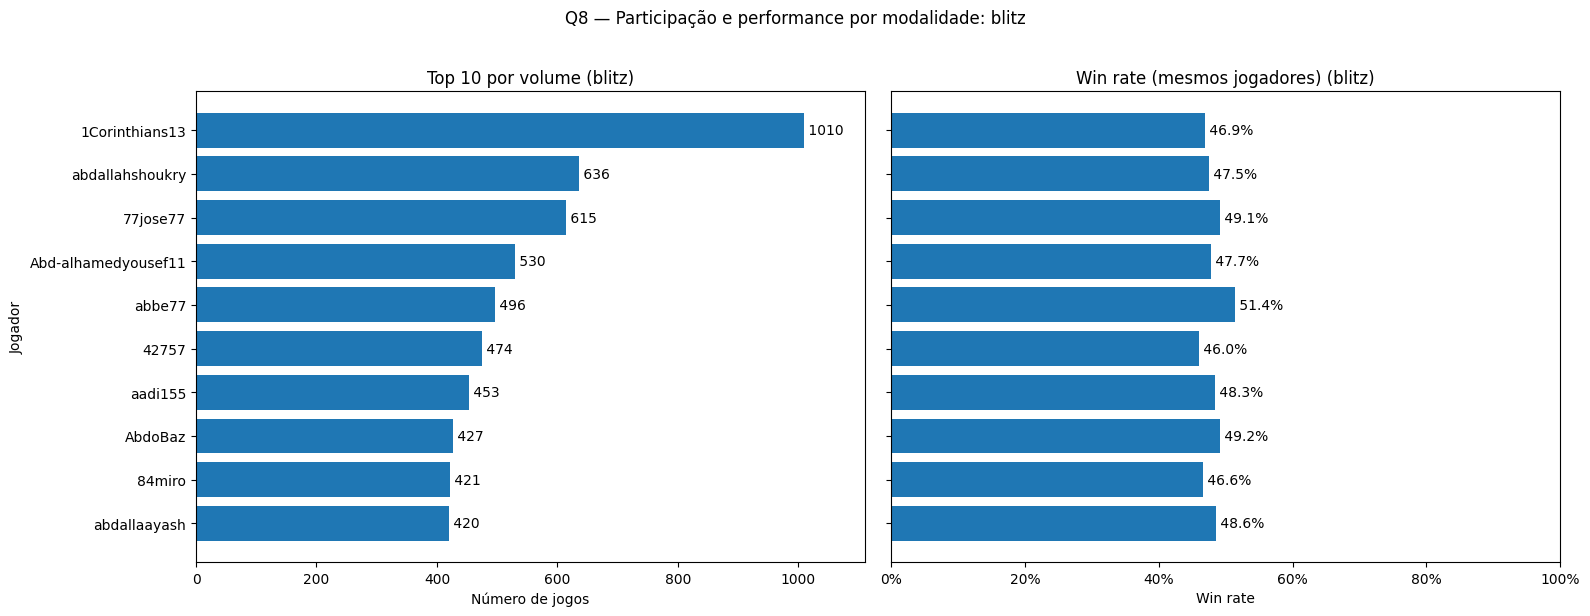

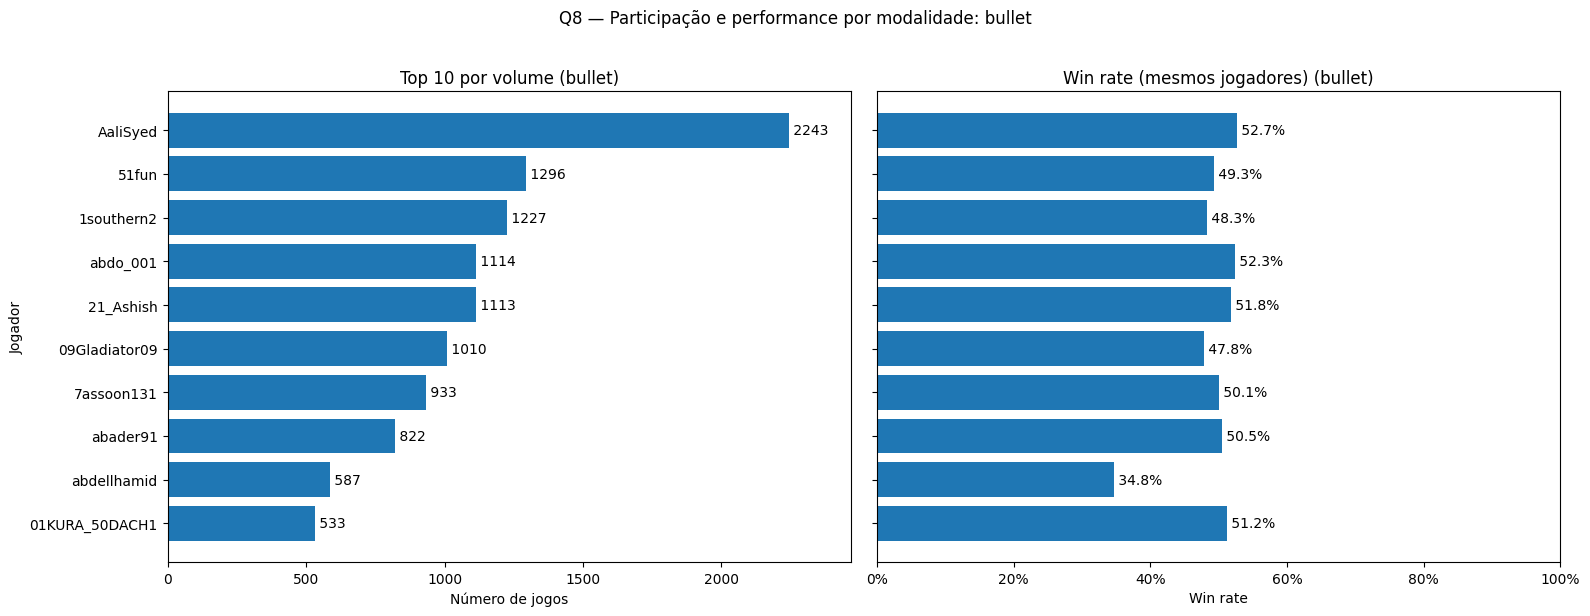

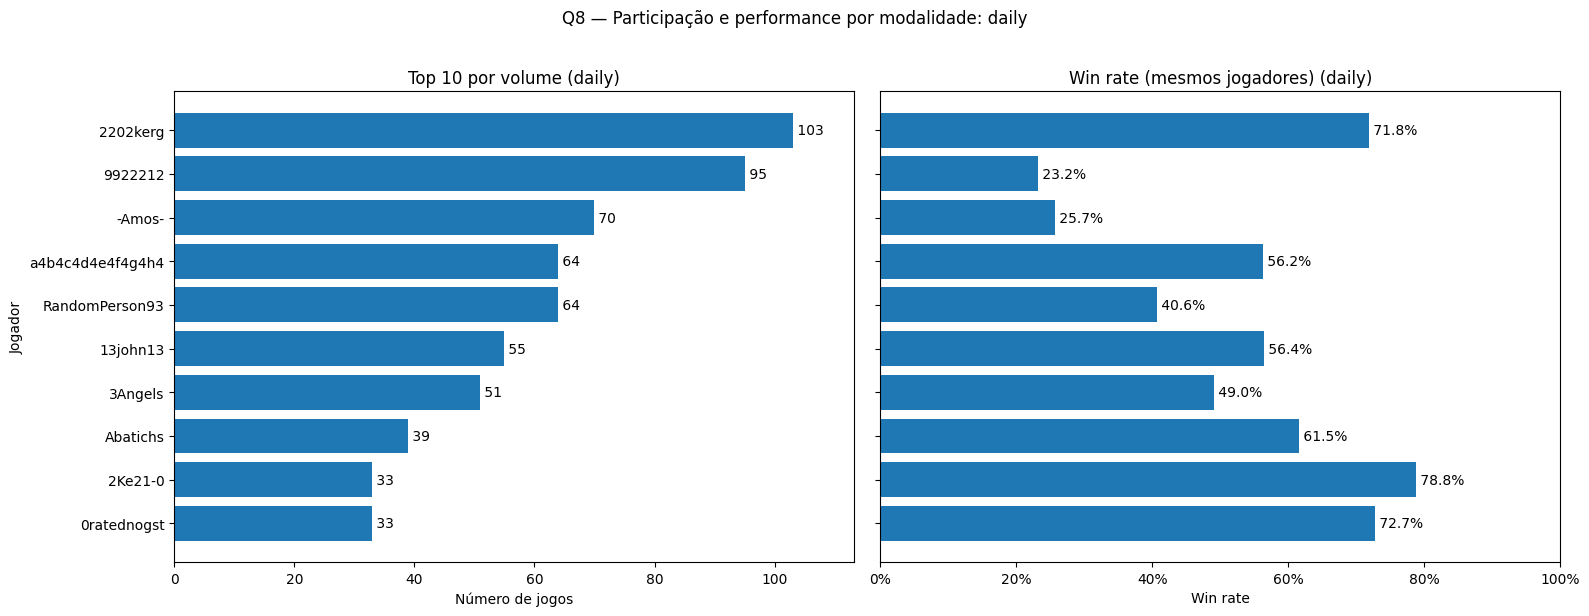

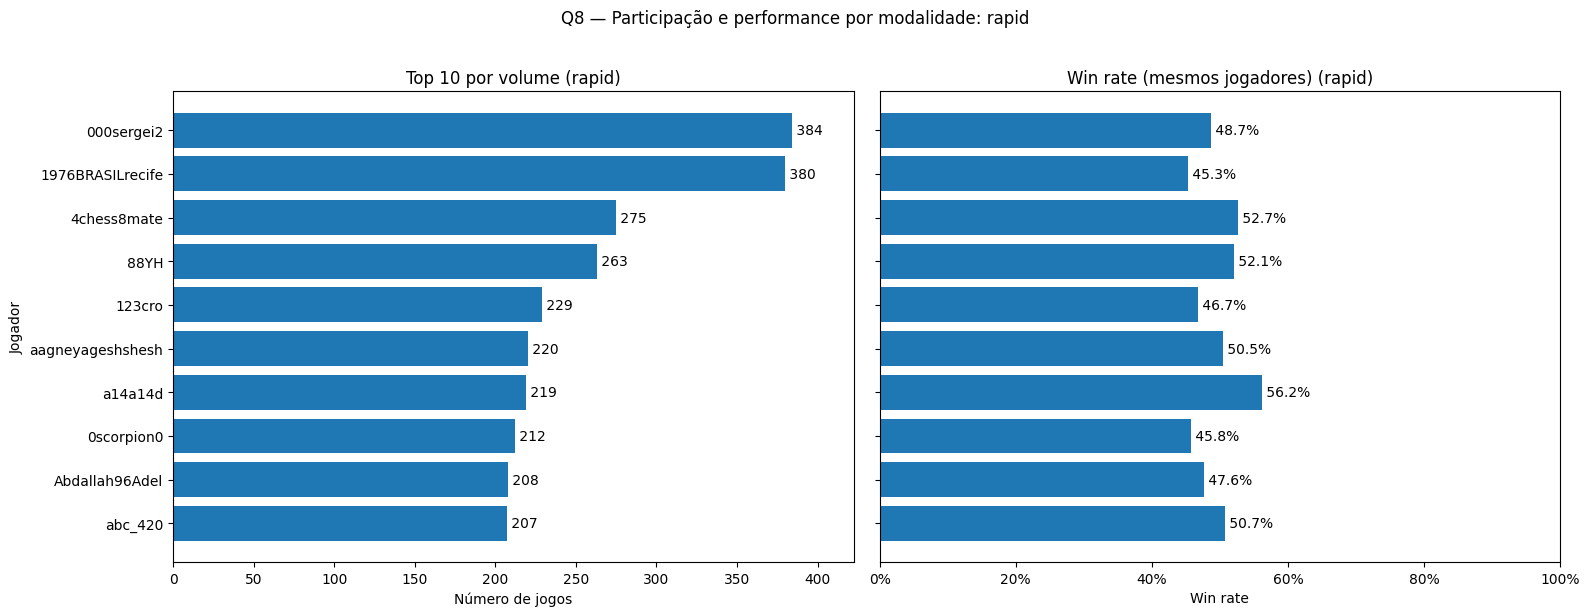

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# _sqldf é o DataFrame gerado pela célula %sql anterior
df = _sqldf.toPandas().copy()

for tc in sorted(df["time_class"].dropna().unique()):
    sub = df[df["time_class"] == tc].sort_values("n_games", ascending=True)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # --- (1) Volume ---
    bars1 = axes[0].barh(sub["player"], sub["n_games"])

    max_games = sub["n_games"].max()
    axes[0].set_xlim(0, max_games * 1.10)  # +10% de folga à direita

    axes[0].set_xlabel("Número de jogos")
    axes[0].set_ylabel("Jogador")
    axes[0].set_title(f"Top 10 por volume ({tc})")

    for b in bars1:
        w = b.get_width()
        axes[0].text(w, b.get_y() + b.get_height()/2, f" {int(w)}", va="center")


    # --- (2) Win rate ---
    bars2 = axes[1].barh(sub["player"], sub["win_rate"])
    axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axes[1].set_xlim(0, 1)
    axes[1].set_xlabel("Win rate")
    axes[1].set_title(f"Win rate (mesmos jogadores) ({tc})")

    for b in bars2:
        w = b.get_width()
        axes[1].text(w, b.get_y() + b.get_height()/2, f" {w*100:.1f}%", va="center")

    fig.suptitle(f"Q8 — Participação e performance por modalidade: {tc}", y=1.02)
    plt.tight_layout()
    plt.show()

    print()
    print()
    print()

### Análise do Resultado (Q8)

De forma geral, os gráficos mostram quem mais joga (volume) e, para esses mesmos jogadores, como performam (win rate). Um ponto importante: volume alto tende a “puxar” o win rate para perto de 50%, enquanto amostras pequenas (especialmente no daily) deixam o win rate bem mais “instável”.


#### Blitz

Há um jogador claramente dominante em volume (bem acima dos demais), sugerindo forte concentração de partidas em poucos usuários.

Os win rates dos top 10 ficam muito próximos de 50%, com variações pequenas. Isso indica equilíbrio geral entre os principais participantes (sem “superdominância” de performance).


#### Bullet

Também há concentração forte de volume (um líder bem acima).

A maioria dos top players fica entre 48% e 53%, mas aparece um caso com win rate bem baixo (\~35%), o que pode indicar perfil outlier de um jogador que joga muito, porém perde bastante, o que pode ter ocorrido por jogar contra oponentes muito fortes.


#### Rapid

Distribuição de volume mais “comportada” (top 2 próximos e o resto descendo gradualmente).

Win rates novamente próximos de 50%, com alguns jogadores um pouco acima (\~56%), sugerindo leve vantagem, mas nada extremo.


#### Daily

Volume é muito menor (top 10 com dezenas de jogos), então o win rate varia muito mais (há valores acima de 70% e outros abaixo de 30%).

Aqui é o melhor exemplo de efeito de amostra pequena: poucos jogos já mudam muito o percentual, então a interpretação deve ser mais cautelosa.




#### Resumo

O dataset é dominado por poucos jogadores em volume (principalmente em bullet e blitz), mas, entre os mais ativos, o desempenho tende a ficar perto de 50% — um sinal de equilíbrio competitivo.

Onde o volume é menor (daily), os win rates parecem mais “extremos”, o que é esperado por volatilidade estatística.